In [2]:
import pandas as pd 
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.inspection import permutation_importance
from scipy.stats import loguniform
import glob
import os
import time

In [3]:
df = pd.read_csv('data/train/kickstarter_train_final_20221022-142838.csv')
test = pd.read_csv('data/test/kickstarter_test_final_20221022-162938.csv')

In [4]:
scaler = MinMaxScaler() 
df[['reward_tiers', 'min_reward', 'max_reward', 'goal']] = scaler.fit_transform(df[['reward_tiers', 'min_reward', 'max_reward', 'goal']])
test[['reward_tiers', 'min_reward', 'max_reward', 'goal']] = scaler.transform(test[['reward_tiers', 'min_reward', 'max_reward', 'goal']])

<h1>Get to the correct data format</h1>

In [5]:
X_train, y_train = df.drop('state', axis=1), df['state']
X_test, y_test = test.drop('state', axis=1), test['state']

In [6]:
X_train.dtypes.unique()

array([dtype('float64'), dtype('int64')], dtype=object)

<h3>Training using Logisitic Regression Model</h3>

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(24756, 578)
(24756,)
(4369, 578)
(4369,)


In [8]:
LRModel = LogisticRegression(max_iter=25000)
LRModel.fit(X_train, y_train)
# Train set
LRModel_train_score = LRModel.score(X_train, y_train)
print('Train Set Accuracy Score: ', LRModel_train_score)
pred = LRModel.predict(X_train)
print("Train Set Confusion Matrix \n", confusion_matrix(y_train, pred))
print("Train Set",classification_report(y_train, pred))

area_under_curve_train = metrics.roc_auc_score(y_train, pred)
print("Area Under Curve:", area_under_curve_train)

Train Set Accuracy Score:  0.9168282436581031
Train Set Confusion Matrix 
 [[ 5935  1339]
 [  720 16762]]
Train Set               precision    recall  f1-score   support

           0       0.89      0.82      0.85      7274
           1       0.93      0.96      0.94     17482

    accuracy                           0.92     24756
   macro avg       0.91      0.89      0.90     24756
weighted avg       0.92      0.92      0.92     24756

Area Under Curve: 0.8873672474837783


In [18]:
#Test Set
LRModel_test_score = LRModel.score(X_test, y_test)
print('Test Set Accuracy Score: ', LRModel_test_score)
test_pred = LRModel.predict(X_test)
print("Test Set Confusion Matrix \n", confusion_matrix(y_test, test_pred))
print("Test Set",classification_report(y_test, test_pred))

area_under_curve_test = metrics.roc_auc_score(y_test, test_pred)
print("Area Under Curve:", area_under_curve_test)

Test Set Accuracy Score:  0.9127946898603799
Test Set Confusion Matrix 
 [[1054  228]
 [ 153 2934]]
Test Set               precision    recall  f1-score   support

           0       0.87      0.82      0.85      1282
           1       0.93      0.95      0.94      3087

    accuracy                           0.91      4369
   macro avg       0.90      0.89      0.89      4369
weighted avg       0.91      0.91      0.91      4369

Area Under Curve: 0.8862951019498506


## Hyper parameter tuning

In [14]:
#using repeatedStratifiedKfold 
model = LogisticRegression(max_iter=25000)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=999)
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l1', 'l2']
space['C'] = loguniform(1e-5, 100)

#define search
search = RandomizedSearchCV(
    model, 
    space, 
    n_iter=10, 
    scoring='roc_auc', 
    n_jobs=-1, 
    cv=cv, 
    verbose=2,
    random_state=999)

# execute search
result = search.fit(X_train, y_train)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

# Best Score: 0.9573322780023994
# Best Hyperparameters: {'C': 4.207230251572931, 'penalty': 'l2', 'solver': 'lbfgs'}

Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best Score: 0.9573322780023994
Best Hyperparameters: {'C': 4.207230251572931, 'penalty': 'l2', 'solver': 'lbfgs'}


<h3> Testing with training model output </h3>

In [16]:
best_model = LogisticRegression(**result.best_params_, max_iter=25000)
best_model.fit(X_train, y_train)
# Train set
best_model_train_score = best_model.score(X_train, y_train)
print('Train Set Accuracy Score after tuning: ', best_model_train_score)
pred1 = best_model.predict(X_train)
print("Train Set Confusion Matrix \n", confusion_matrix(y_train, pred1))
print("Train Set",classification_report(y_train, pred1))

area_under_curve_train = metrics.roc_auc_score(y_train, pred1)
print("Area Under Curve after tuning:", area_under_curve_train)

Train Set Accuracy Score after tuning:  0.9194134755210858
Train Set Confusion Matrix 
 [[ 6007  1267]
 [  728 16754]]
Train Set               precision    recall  f1-score   support

           0       0.89      0.83      0.86      7274
           1       0.93      0.96      0.94     17482

    accuracy                           0.92     24756
   macro avg       0.91      0.89      0.90     24756
weighted avg       0.92      0.92      0.92     24756

Area Under Curve after tuning: 0.892087574612665


In [17]:
best_model_test_score = best_model.score(X_test, y_test)
print('Test Set Accuracy Score: ', best_model_test_score)
test_pred1 = best_model.predict(X_test)
print("Test Set Confusion Matrix \n", confusion_matrix(y_test, test_pred1))
print("Test Set",classification_report(y_test, test_pred1))

area_under_curve_test = metrics.roc_auc_score(y_test, test_pred1)
print("Area Under Curve:", area_under_curve_test)

Test Set Accuracy Score:  0.9148546578164339
Test Set Confusion Matrix 
 [[1071  211]
 [ 161 2926]]
Test Set               precision    recall  f1-score   support

           0       0.87      0.84      0.85      1282
           1       0.93      0.95      0.94      3087

    accuracy                           0.91      4369
   macro avg       0.90      0.89      0.90      4369
weighted avg       0.91      0.91      0.91      4369

Area Under Curve: 0.8916296107626617


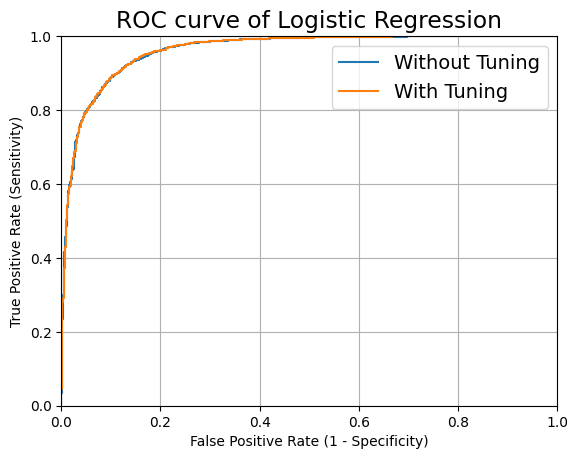

In [19]:
import matplotlib.pyplot as plt
test_predict = LRModel.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_predict)
plt.plot(fpr, tpr, label = "Without Tuning")
test_predict1 = best_model.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, test_predict1)
plt.plot(fpr1, tpr1, label = "With Tuning")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 14
plt.title('ROC curve of Logistic Regression')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend()
plt.grid(True)

### Run Time

In [20]:
%%time
start_time = time.time()
model_time = LogisticRegression(**result.best_params_, max_iter=25000)
model_time.fit(X_train, y_train)
test_pred1 = model_time.predict(X_test)
print("Execution time: " + str((time.time() - start_time)) + ' s')

Execution time: 8.03834867477417 s
Wall time: 8.04 s


### Feature Importance

In [21]:
imps = permutation_importance(model_time, X_test, y_test)
imps_sorted = imps.importances_mean.argsort()[::-1]

print(np.take(X_train.columns, imps_sorted[: 20]))

Index(['success_rate', 'rewards_1', 'rewards_0', 'rewards_5', 'reward_tiers',
       'rewards_35', 'rewards_34', 'funding_duration_in_days', 'x0_journalism',
       'rewards_15', 'rewards_2', 'rewards_62', 'x0_GB', 'rewards_3',
       'rewards_60', 'rewards_61', 'description_story_54', 'rewards_38',
       'description_story_75', 'x0_film & video'],
      dtype='object')
